**Loading Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

Loading the dataset

In [4]:
df = pd.read_csv('/content/colorado_motor_vehicle_sales.csv')

In [5]:
df.head()

,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


Data Preprocessing

In [6]:
# Creating Date column using year and quarter
quarter_month_map = {1: 1, 2: 4, 3: 7, 4: 10}
df['Month'] = df['quarter'].map(quarter_month_map)
df['Date'] = pd.to_datetime(dict(year=df['year'], month = df['Month'], day=1))
df.drop(columns='Month', inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

In [7]:
# Creating a new column that represents the year and quarter
df['period'] = df['year'].astype(str)+' Q' + df['quarter'].astype(str)

In [8]:
# Aggregeate sales by quarter across all counties
quarterly_sales = df.groupby('Date')['sales'].sum().to_frame()
quarterly_sales['year']=quarterly_sales.index.year
quarterly_sales['quarter'] = quarterly_sales.index.quarter
yearly_sales = quarterly_sales.groupby('year')['sales'].sum().reset_index()

Exploratory Data Analysis

In [9]:
def perform_eda(df):
  print(f"Shape of the dataFrame: {df.shape}\n")
  print(f"Data types:\n{df.dtypes}\n")
  print(f"Missing values:\n{df.isnull().sum()}\n")
  print(f"Summary statistics:\n{df.describe()}\n")

perform_eda(df)

Shape of the dataFrame: (501, 5)

Data types:
year        int64
quarter     int64
county     object
sales       int64
period     object
dtype: object

Missing values:
year       0
quarter    0
county     0
sales      0
period     0
dtype: int64

Summary statistics:
              year     quarter         sales
count   501.000000  501.000000  5.010000e+02
mean   2011.570858    2.502994  1.760585e+08
std       2.266599    1.120041  1.642055e+08
min    2008.000000    1.000000  6.274000e+06
25%    2010.000000    2.000000  6.148200e+07
50%    2012.000000    3.000000  1.385820e+08
75%    2014.000000    4.000000  2.241580e+08
max    2015.000000    4.000000  9.169100e+08



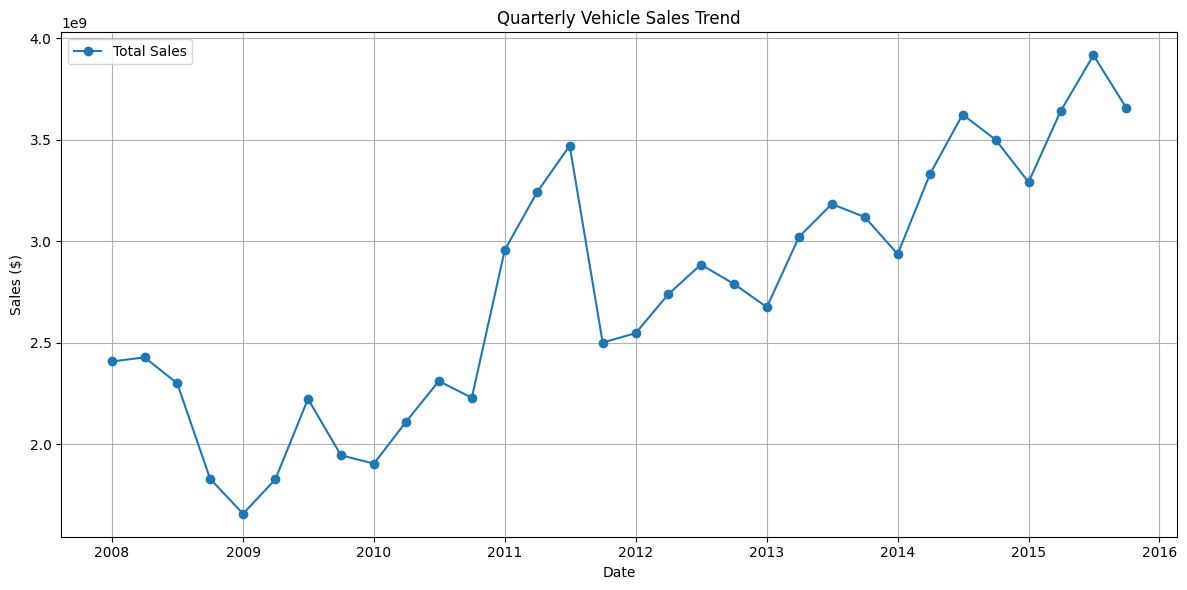

In [10]:
# Line Plot - Quarterly Sales Trend
plt.figure(figsize=(12,6))
plt.plot(quarterly_sales.index, quarterly_sales['sales'], marker='o', label='Total Sales')
plt.title('Quarterly Vehicle Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def plot_sales_by_county(df, year, quarter):
  # Filter the DataFramef for the selected year and quarter
  filtered_df = df[(df['year'] == year) & (df['quarter'] == quarter)]

  # Group the data by county and sum the tables
  county_sales = filtered_df.groupby('county')['sales'].sum().reset_index()

  # Sort the counties by sales
  county_sales_sorted = county_sales.sort_values('sales', ascending=False)
  #Bar Plot - Total Sales by year
  plt.figure(figsize=(12,6))
  sns.barplot(x='county', y='sales', data=county_sales_sorted, palette = 'viridis')
  plt.title(f'Sales by County for {year} Q{quarter}')
  plt.xlabel('County')
  plt.ylabel('Total Sales($)')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

# Creating widgets for year and quarter selection
year_widget = widgets.IntSlider(min=df['year'].min(), max=df['year'].max(), step=1, description='Year:')
quarter_widget = widgets.IntSlider(min=df['quarter'].min(), max=df['quarter'].max(), step=1, description='Quarter:')

widgets.interact(lambda year, quarter: plot_sales_by_county(df, year, quarter), year=year_widget, quarter=quarter_widget)


interactive(children=(IntSlider(value=2008, description='Year:', max=2015, min=2008), IntSlider(value=1, descr…

<function __main__.<lambda>(year, quarter)>

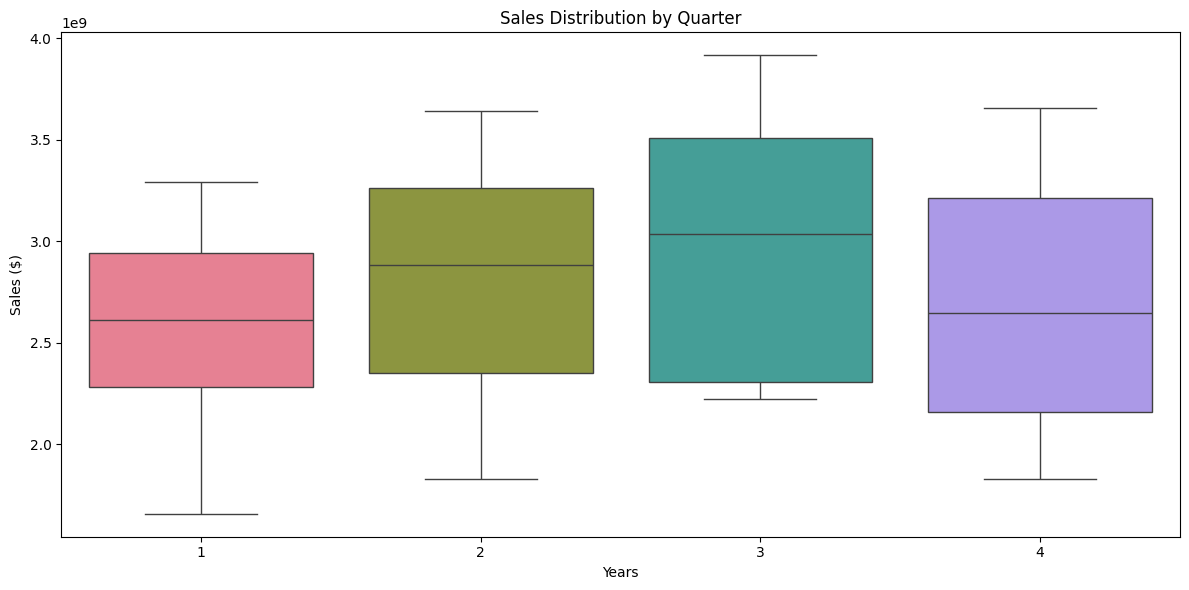

In [12]:
# Box plot - Quarterly Sales by Year
plt.figure(figsize=(12,6))
sns.boxplot(x='quarter', y='sales', data=quarterly_sales.reset_index(), palette='husl')
plt.title('Sales Distribution by Quarter')
plt.xlabel('Years')
plt.ylabel('Sales ($)')
plt.tight_layout()
plt.show()

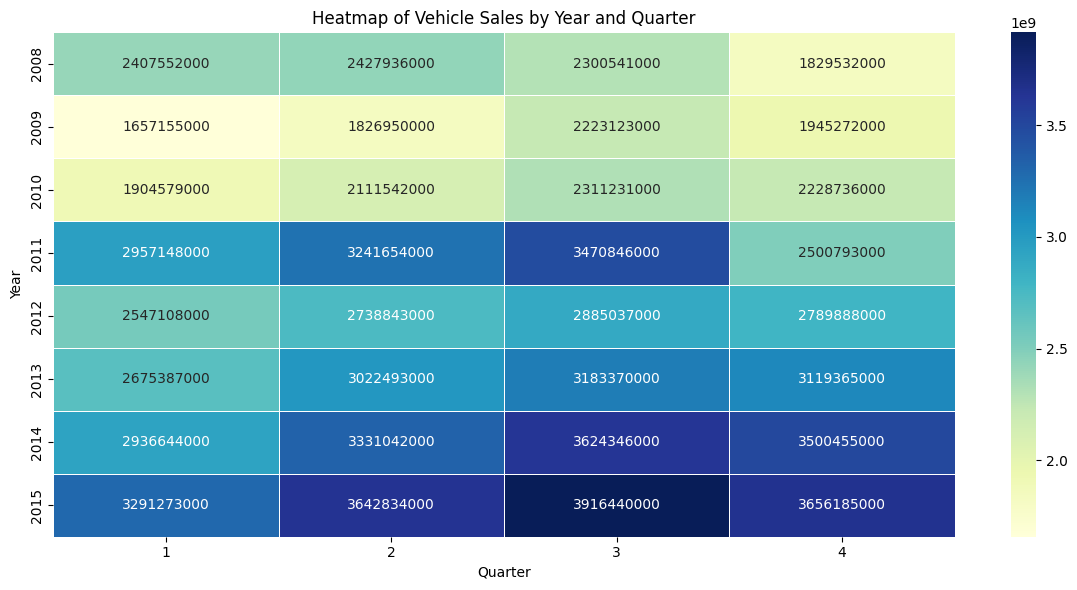

In [13]:
# Heatmap - Sales per year quarter
pivot_table = quarterly_sales.pivot_table(values='sales', index = 'year', columns='quarter')
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.0f', linewidths=.5)
plt.title('Heatmap of Vehicle Sales by Year and Quarter')
plt.xlabel('Quarter')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

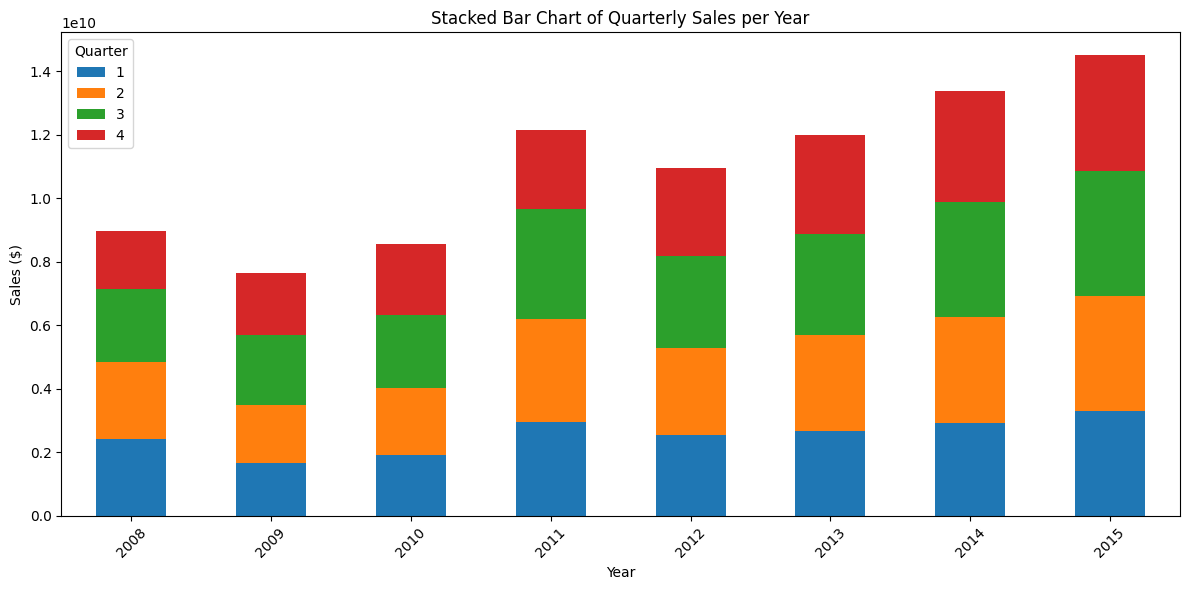

In [14]:
# Stacked Bar Chart  - Quarterly Sales per Year
stacked_df = quarterly_sales.pivot_table(values='sales', index='year', columns='quarter')
stacked_df.plot(kind = 'bar', stacked='True', figsize=(12,6))
plt.title('Stacked Bar Chart of Quarterly Sales per Year')
plt.xlabel('Year')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

Seasonal Decomposition

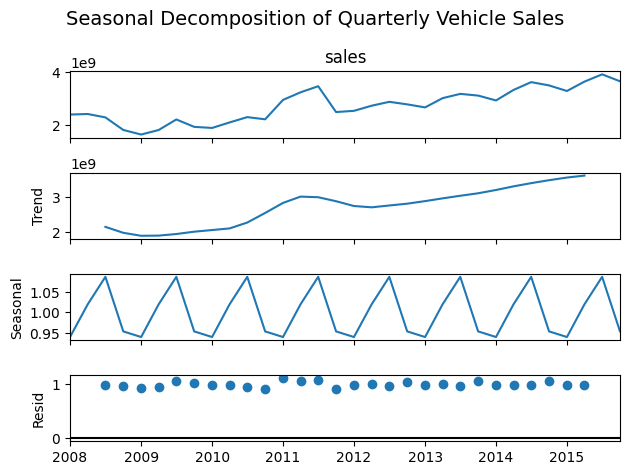

In [15]:
decomposition = seasonal_decompose(quarterly_sales['sales'], model='multiplicative', period=4)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Quarterly Vehicle Sales', fontsize=14)
plt.tight_layout()
plt.show()

Random Forest

In [16]:
# Convert County Column into categorical
df['county'] = df['county'].astype('category').cat.codes

# Define features and target
X = df[['year', 'quarter', 'county']]
y = df['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Initializa the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make prediction
y_pred = model.predict(X_test)

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_rf}")

RMSE: 20402876.97387048


Grid Search

In [17]:
# Parameter Grid
param_grid = {
    'n_estimators' : [50,100,200],
    'max_depth': [None, 10, 20,30],
    'min_samples_split': [2,5,10]
}

# Initialize the model
model = RandomForestRegressor(random_state=42)

#Initialize the drid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the parameters
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

#Fit the model with the best parameters
model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse_gd = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_gd}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 19981856.206187755


Linear Regression Model

In [18]:
quarterly_sales['time_index'] = np.arange(len(quarterly_sales))

In [19]:
X = quarterly_sales[['time_index']]
y = quarterly_sales['sales']
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False, test_size=0.2)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)
print(f"RMSE: {lr_rmse}")

RMSE: 300975767.0466491


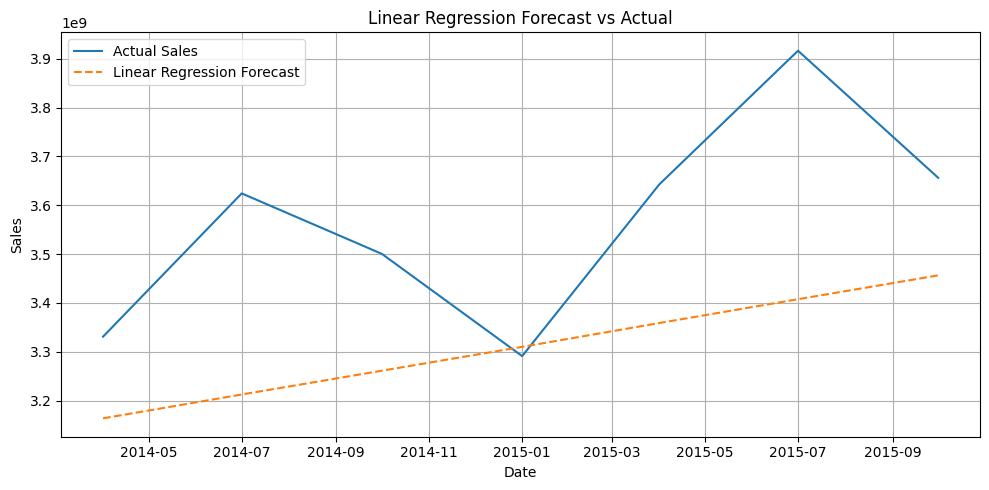

In [20]:
# Plot Linear Regression Forecast
pred_dates = quarterly_sales.index[-len(y_test):]
plt.figure(figsize=(10,5))
plt.plot(pred_dates, y_test, label='Actual Sales')
plt.plot(pred_dates, lr_preds, label='Linear Regression Forecast', linestyle='--')
plt.title('Linear Regression Forecast vs Actual')
plt. xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ARIMA Model

In [21]:
arima_model = ARIMA(quarterly_sales['sales'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=8)
forecast_index = pd.date_range(start=quarterly_sales.index[-1]+pd.DateOffset(months=3), periods=8, freq='Q')

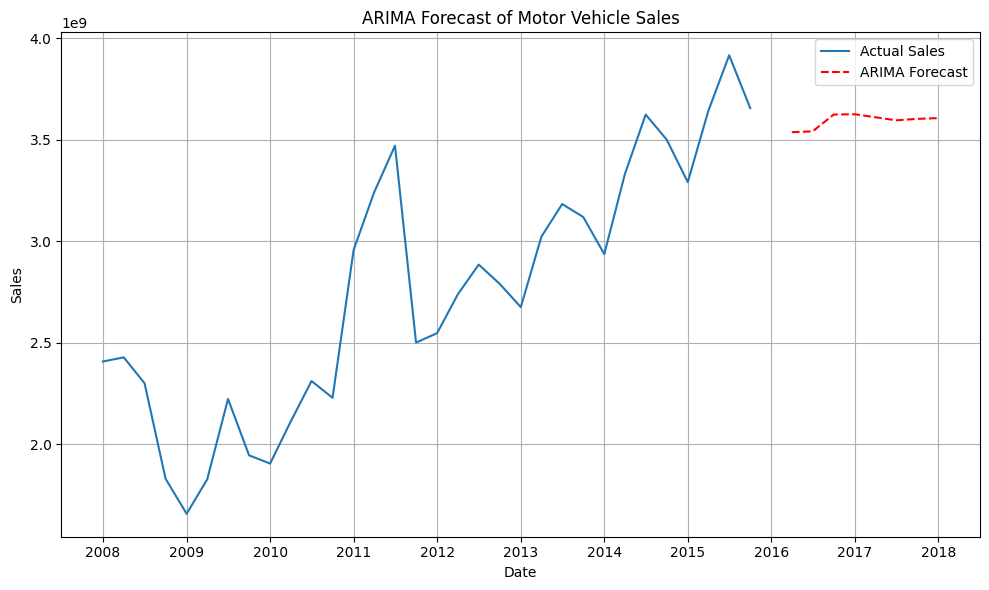

RMSE: 245073191.6558324


In [22]:
# Plotting ARIMA Forecast
plt.figure(figsize=(10,6))
plt.plot(quarterly_sales.index, quarterly_sales['sales'], label='Actual Sales')
plt.plot(forecast_index, arima_forecast, color='red', linestyle='--', label='ARIMA Forecast')
plt.title('ARIMA Forecast of Motor Vehicle Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

arima_mse = mean_squared_error(quarterly_sales['sales'][-8:], arima_fit.predict(start=len(quarterly_sales)-8, end=len(quarterly_sales)-1))
arima_rmse = np.sqrt(arima_mse)
print(f"RMSE: {arima_rmse}")

XGBoost Model

In [23]:
xgb_model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
print(f"RMSE: {xgb_rmse}")

RMSE: 659932225.9201009


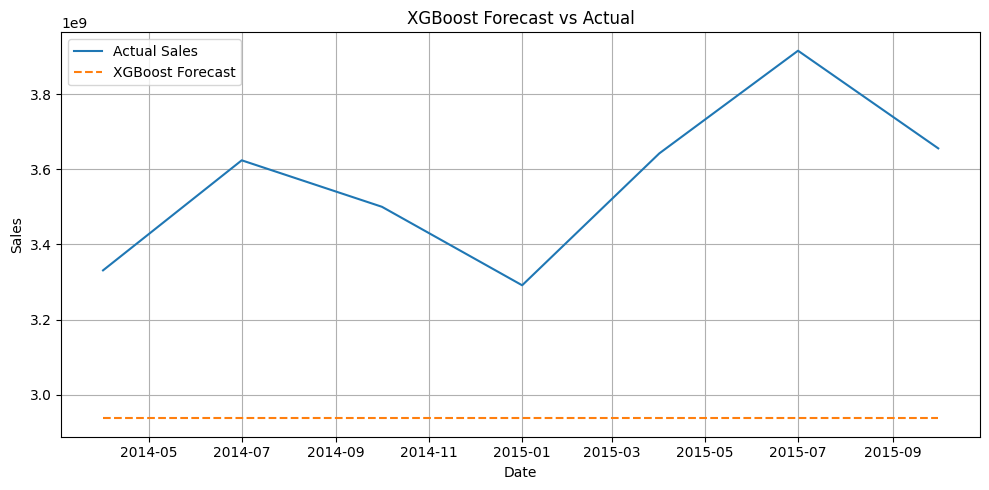

In [24]:
plt.figure(figsize=(10,5))
plt.plot(pred_dates, y_test, label='Actual Sales')
plt.plot(pred_dates, xgb_preds, label='XGBoost Forecast', linestyle='--')
plt.title('XGBoost Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Support Vector Regression (SVR)

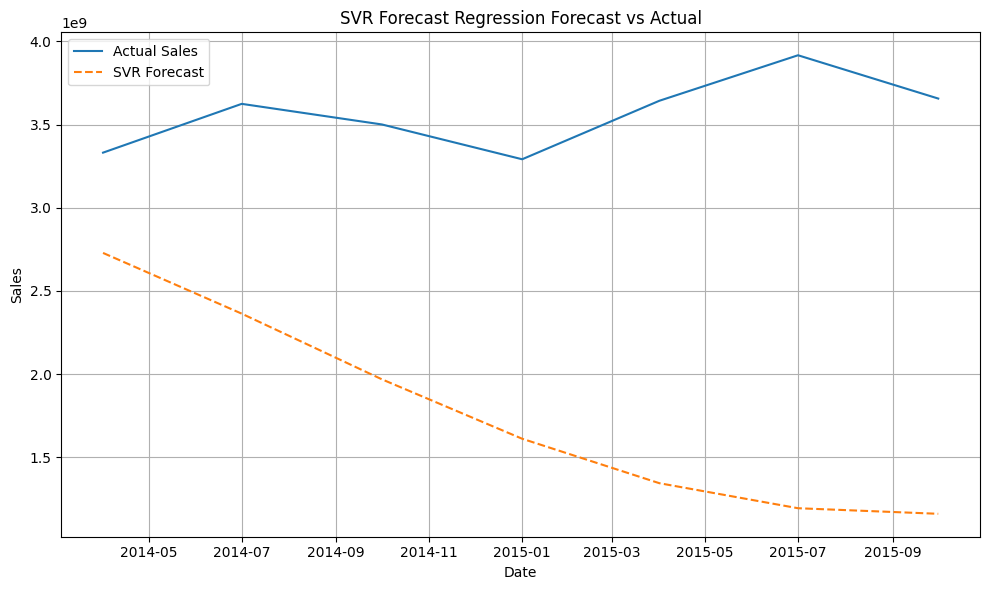

RMSE: 1929132918.621344


In [25]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).ravel()

X_train_scaled, X_test_scaled = train_test_split(X_scaled, shuffle=False, test_size=0.2)
y_train_scaled, y_test_scaled = train_test_split(y_scaled, shuffle=False, test_size=0.2)

svr_model = SVR(kernel='rbf', C=100)
svr_model.fit(X_train_scaled, y_train_scaled)
svr_preds_scaled = svr_model.predict(X_test_scaled)
svr_preds = scaler_y.inverse_transform(svr_preds_scaled.reshape(-1,1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

plt.figure(figsize=(10,6))
plt.plot(pred_dates, y_test_actual, label='Actual Sales')
plt.plot(pred_dates, svr_preds, label='SVR Forecast', linestyle='--')
plt.title('SVR Forecast Regression Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
svr_mse = mean_squared_error(y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)
print(f"RMSE: {svr_rmse}")

Report Summary

In [26]:
report = f"""
Colorado Motor Vehicle Sales Analysis Report
-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-
1. Data Overview:
- Time Frame: {quarterly_sales.index.min().date()} to {quarterly_sales.index.max().date()}
- Number of Quarters: {len(quarterly_sales)}
- Total Sales: ${quarterly_sales['sales'].sum():,.2f}
- Total Data Points (Quarters) : {len(quarterly_sales)}

2. Exploratory Data Analysis:
- Quarterly sales plotted with visible seasonal trends and recession impact (2008-2009).

3. Statistical Analysis:
- Seasonal decomposition revealed clear trends and repeating quarterly patterns.

4. Predictive Modeling
- Random Forest: RMSE = {rmse_rf:.2e}
- Grid Search: RMSE = {rmse_gd:.2e}
- Linear Regression: MSE = {lr_rmse:.2e}
- ARIMA: RMSE = {arima_rmse:.2e}
- XGBoost: RMSE = {xgb_rmse:.2e}
- SVR: RMSE = {svr_rmse:.2e}

5. Conclusion
- SVR provided the most accurate forecast with an RMSE of {svr_rmse:.2e}.
- The model helps understand and predict Colorado's automotive sales, supporting economic planning.
"""
print(report)


Colorado Motor Vehicle Sales Analysis Report
-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-
1. Data Overview:
- Time Frame: 2008-01-01 to 2015-10-01
- Number of Quarters: 32
- Total Sales: $88,205,300,000.00
- Total Data Points (Quarters) : 32

2. Exploratory Data Analysis:
- Quarterly sales plotted with visible seasonal trends and recession impact (2008-2009).

3. Statistical Analysis:
- Seasonal decomposition revealed clear trends and repeating quarterly patterns.

4. Predictive Modeling
- Random Forest: RMSE = 2.04e+07
- Grid Search: RMSE = 2.00e+07
- Linear Regression: MSE = 3.01e+08
- ARIMA: RMSE = 2.45e+08
- XGBoost: RMSE = 6.60e+08
- SVR: RMSE = 1.93e+09

5. Conclusion
- SVR provided the most accurate forecast with an RMSE of 1.93e+09.
- The model helps understand and predict Colorado's automotive sales, supporting economic planning.



In [28]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace "Colorado Motor Vehicle.ipynb"


[NbConvertApp] WARNING | pattern 'Colorado Motor Vehicle.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--

In [1]:
!jupyter nbconvert --to script "Colorado Motor Vehicle.ipynb"


[NbConvertApp] WARNING | pattern 'Colorado Motor Vehicle.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--